# **2. Entrenamiento del Modelo con el Dataset proporcionado**

En esta sección, cargaremos los datos que te fueron proporcionados, realizaremos un breve análisis, entrenaremos el mismo modelo de Red Neuronal Artificial (RNA) que usaste en el punto anterior y evaluaremos su rendimiento.

## **2.1. Fase 1: Entendimiento del Negocio**

El objetivo sigue siendo el mismo: predecir las posibles complicaciones (resultados letales) de un infarto de miocardio. Sin embargo, en este caso, utilizaremos un conjunto de datos que ya ha sido preprocesado e imputado, dividido en archivos de entrenamiento y prueba. Nuestra meta es entrenar el modelo de RNA con estos datos y comparar su rendimiento con el modelo que entrenamos previamente con nuestro propio preprocesamiento.

## **2.2. Fase 2: Entendimiento de los Datos**

Necesitamos subir los archivos X_imp_train.csv, y_imp_train.csv, X_imp_test.csv y y_imp_test.csv.

In [ ]:
!pip install -q imbalanced-learn

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
# Cargar los conjuntos de datos de entrenamiento y prueba
X_train_imp = pd.read_csv('./X_imp_train.csv')
y_train_imp = pd.read_csv('./y_imp_train.csv')
X_test_imp = pd.read_csv('./X_imp_test.csv')
y_test_imp = pd.read_csv('./y_imp_test.csv')

### **2.2.2. Análisis Exploratorio Inicial**

Ahora, vamos a realizar una exploración básica para entender la estructura y características de estos nuevos datos.

Dimensiones de X_train_imp: (1138, 101)
Dimensiones de y_train_imp: (1138, 1)
Dimensiones de X_test_imp: (561, 101)
Dimensiones de y_test_imp: (561, 1)

Primeras 5 filas de X_train_imp:
    AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  SIM_GIPERT  \
0  59.0    1       0.0        5.0        2.0       1.0  2.0         0.0   
1  53.0    1       0.0        0.0        0.0       2.0  0.0         1.0   
2  74.0    0       0.0        6.0        2.0       1.0  0.0         0.0   
3  79.0    0       2.0        1.0        3.0       1.0  3.0         0.0   
4  47.0    0       1.0        2.0        2.0       2.0  2.0         0.0   

   DLIT_AG  ZSN_A  ...  NITR_S  NA_R_1_n  NOT_NA_1_n  LID_S_n  B_BLOK_S_n  \
0      2.0    3.0  ...     0.0       0.0         0.0      0.0         0.0   
1      4.0    0.0  ...     0.0       0.0         0.0      0.0         0.0   
2      0.0    0.0  ...     0.0       0.0         0.0      0.0         0.0   
3      7.0    0.0  ...     0.0       0.0         0.0   

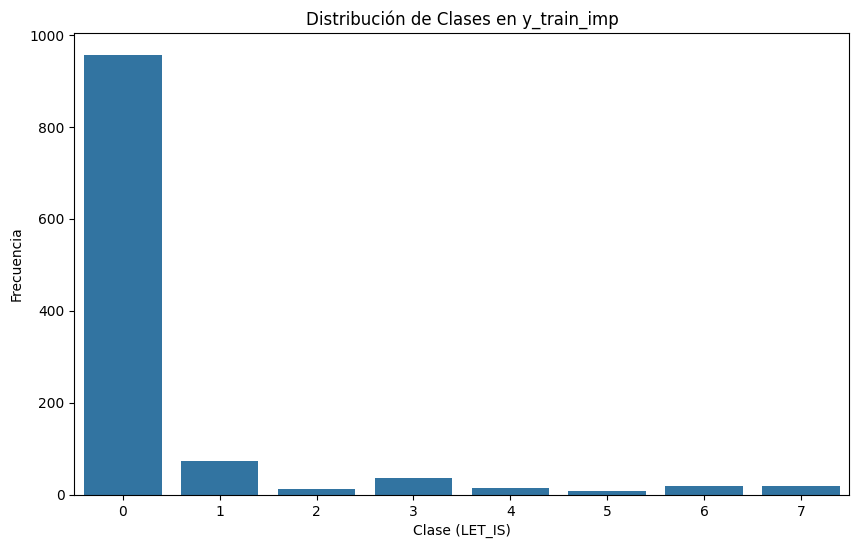

In [ ]:
# Dimensiones de los dataframes
print(f"Dimensiones de X_train_imp: {X_train_imp.shape}")
print(f"Dimensiones de y_train_imp: {y_train_imp.shape}")
print(f"Dimensiones de X_test_imp: {X_test_imp.shape}")
print(f"Dimensiones de y_test_imp: {y_test_imp.shape}")

# Visualizar las primeras filas de los datos de entrenamiento
print("\nPrimeras 5 filas de X_train_imp:")
print(X_train_imp.head())

# Visualizar las primeras filas de la variable objetivo
print("\nPrimeras 5 filas de y_train_imp:")
print(y_train_imp.head())

# Analizar la distribución de la variable objetivo en el conjunto de entrenamiento
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=y_train_imp, x='LET_IS')
plt.title('Distribución de Clases en y_train_imp')
plt.xlabel('Clase (LET_IS)')
plt.ylabel('Frecuencia')
plt.show()

## **2.3. Fase 3: Preparación de los Datos**

Aunque los datos ya están imputados y divididos, aún debemos realizar dos pasos clave que hicimos con el modelo final anterior: la codificación de la variable objetivo y la normalización de las características.

### **2.3.1. Codificación de la Variable Objetivo (One-Hot Encoding)**

El modelo MLPClassifier para clasificación multiclase espera que la salida y esté en formato one-hot encoded.


In [ ]:
# Codificar la variable objetivo 'y' para ambos conjuntos (entrenamiento y prueba)
y_train_imp_encoded = pd.get_dummies(y_train_imp['LET_IS'], prefix='class', dtype=int)
y_test_imp_encoded = pd.get_dummies(y_test_imp['LET_IS'], prefix='class', dtype=int)

print("Primeras 5 filas de y_train_imp_encoded:")
print(y_train_imp_encoded.head())

Primeras 5 filas de y_train_imp_encoded:
   class_0  class_1  class_2  class_3  class_4  class_5  class_6  class_7
0        1        0        0        0        0        0        0        0
1        1        0        0        0        0        0        0        0
2        1        0        0        0        0        0        0        0
3        1        0        0        0        0        0        0        0
4        1        0        0        0        0        0        0        0


### **2.3.2. Identificación de Tipos de Variables**

In [ ]:
numerical_features = [col for col in X_train_imp.columns if X_train_imp[col].nunique() > 25]
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].nunique() <= 25]

# Es importante asegurarse de que las columnas categóricas se traten como tales.
# SMOTENC requiere los índices de las columnas categóricas.
categorical_features_indices = [X_train_imp.columns.get_loc(col) for col in categorical_features]

print(f"Columnas numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Columnas categóricas ({len(categorical_features)}): {categorical_features[:5]}...")

Columnas numéricas (9): ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE']
Columnas categóricas (92): ['SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST']...


### **2.3.3. Preparación de Conjuntos de Datos para los Experimentos**
Primero, definiremos la función de evaluación y los parámetros que usaremos en todos los experimentos para no repetirlos.

In [ ]:
def evaluate_classifier_and_get_metrics(classifier, x_test, y_test, target_names, title_prefix=""):
    print(f"\n--- {title_prefix} ---")
    y_pred = classifier.predict(x_test)

    # Obtener reporte de clasificación como un diccionario
    report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)

    # Obtener accuracy general
    accuracy = accuracy_score(y_test, y_pred)
    report_dict['accuracy'] = accuracy  # Añadir accuracy al diccionario

    # Imprimir resumen
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

    # Matriz de Confusión
    y_test_labels = np.argmax(y_test.values, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test_labels, y_pred_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión - {title_prefix}')
    plt.show()

    # Retornar el diccionario con todas las métricas
    return report_dict

# Parametros del modelo
model_seed = 7
target_names = [
    'unknown (alive)', 'cardiogenic shock', 'pulmonary edema',
    'myocardial rupture', 'progress of CHF', 'thromboembolism',
    'asystole', 'ventricular fib.' # Nombres más cortos para la tabla
]
random.seed(model_seed)
np.random.seed(model_seed)

# Diccionario para almacenar resultados de cada prueba
all_metrics = {}

### **A. Prueba 1: Modelo Base (Antes de Balancear y Antes de Normalizar)**

Este es nuestro punto de partida, usando los datos tal como vienen (excepto la imputación ya hecha y el one-hot encoding).


--- ANTES de Balancear y Normalizar ---
Overall Accuracy: 0.8342

Classification Report:
                    precision    recall  f1-score   support

   unknown (alive)       0.89      0.97      0.93       471
 cardiogenic shock       0.68      0.36      0.47        36
   pulmonary edema       0.00      0.00      0.00         6
myocardial rupture       0.00      0.00      0.00        18
   progress of CHF       0.00      0.00      0.00         8
   thromboembolism       0.00      0.00      0.00         4
          asystole       0.00      0.00      0.00         9
  ventricular fib.       0.00      0.00      0.00         9

         micro avg       0.88      0.83      0.86       561
         macro avg       0.20      0.17      0.17       561
      weighted avg       0.79      0.83      0.81       561
       samples avg       0.83      0.83      0.83       561



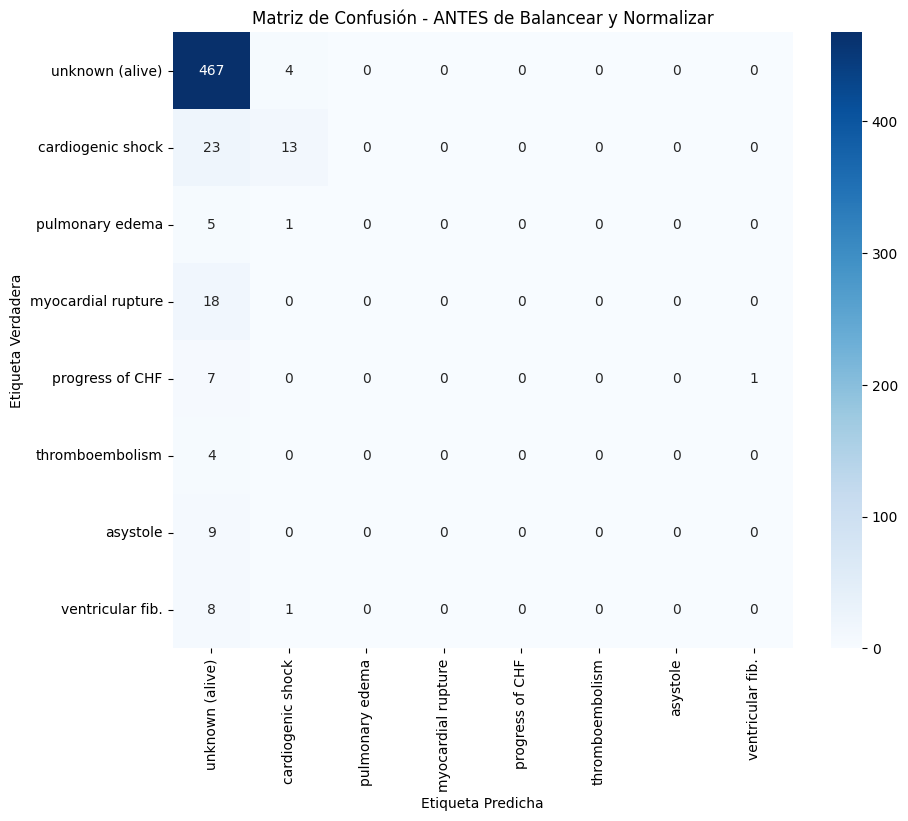

In [ ]:
classifier_base = MLPClassifier(solver='adam', random_state=model_seed, activation='relu', alpha=1e-12, tol=1e-12,
                               hidden_layer_sizes=(10,8), learning_rate='constant',
                               learning_rate_init=0.01, max_iter=500, momentum=0.9, verbose=False)

classifier_base.fit(X_train_imp, y_train_imp_encoded)

all_metrics['Modelo Base'] = evaluate_classifier_and_get_metrics(classifier_base, X_test_imp, y_test_imp_encoded, target_names, title_prefix="ANTES de Balancear y Normalizar")


### **B. Prueba 2: Modelo con Normalización**



--- DESPUÉS de Normalizar ---
Overall Accuracy: 0.7736

Classification Report:
                    precision    recall  f1-score   support

   unknown (alive)       0.89      0.92      0.91       471
 cardiogenic shock       0.54      0.42      0.47        36
   pulmonary edema       0.00      0.00      0.00         6
myocardial rupture       0.20      0.17      0.18        18
   progress of CHF       0.25      0.12      0.17         8
   thromboembolism       0.00      0.00      0.00         4
          asystole       0.00      0.00      0.00         9
  ventricular fib.       0.06      0.11      0.08         9

         micro avg       0.82      0.81      0.82       561
         macro avg       0.24      0.22      0.23       561
      weighted avg       0.80      0.81      0.80       561
       samples avg       0.79      0.81      0.80       561



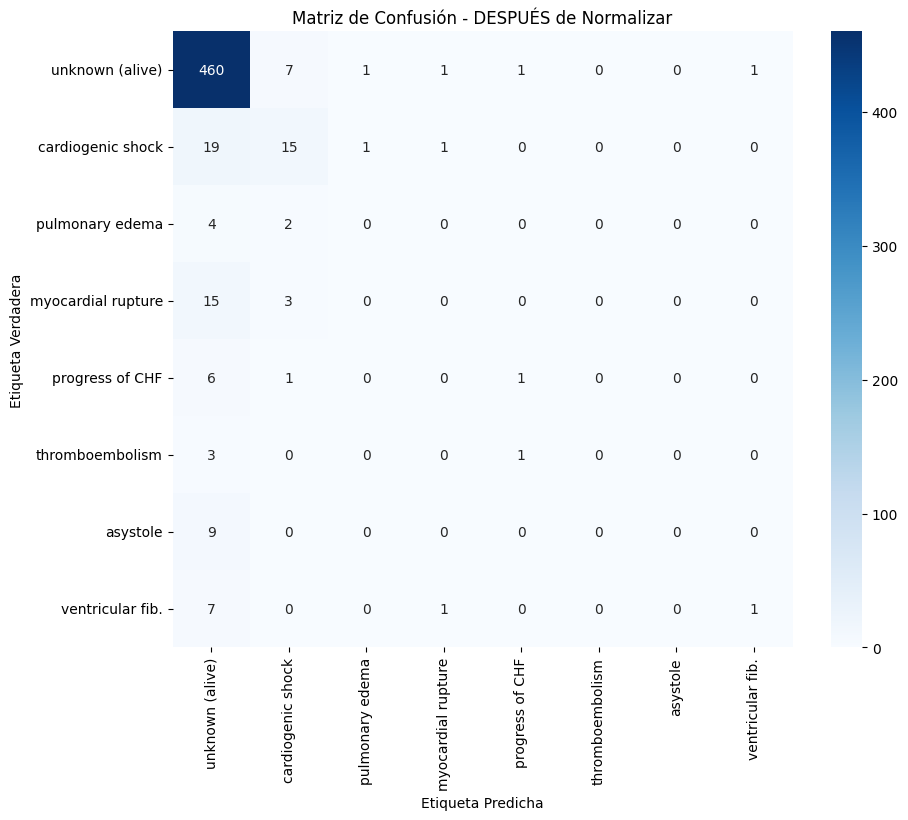

In [ ]:
# Identificar columnas numéricas y categóricas (one-hot encoded)
columnas_numericas = [col for col in X_train_imp.columns if len(X_train_imp[col].unique()) > 2]
columnas_categoricas = [col for col in X_train_imp.columns if len(X_train_imp[col].unique()) <= 2]

# Crear DataFrames separados para facilitar la manipulación
X_train_imp_num = X_train_imp[columnas_numericas]
X_train_imp_cat = X_train_imp[columnas_categoricas]
X_test_imp_num = X_test_imp[columnas_numericas]
X_test_imp_cat = X_test_imp[columnas_categoricas]

# Inicializar y ajustar el normalizador SOLO con los datos numéricos de entrenamiento
scaler_norm = MinMaxScaler()
X_train_imp_norm_num = scaler_norm.fit_transform(X_train_imp_num)

# Usar el MISMO scaler ajustado para transformar los datos de prueba
X_test_imp_norm_num = scaler_norm.transform(X_test_imp_num)

# Convertir los arrays normalizados de nuevo a DataFrames para mantener los nombres de las columnas
X_train_imp_norm_num_df = pd.DataFrame(X_train_imp_norm_num, columns=columnas_numericas, index=X_train_imp_num.index)
X_test_imp_norm_num_df = pd.DataFrame(X_test_imp_norm_num, columns=columnas_numericas, index=X_test_imp_num.index)

# Unir las columnas numéricas normalizadas con las categóricas originales
X_train_imp_norm_final = pd.concat([X_train_imp_norm_num_df, X_train_imp_cat], axis=1)
X_test_imp_norm_final = pd.concat([X_test_imp_norm_num_df, X_test_imp_cat], axis=1)

classifier_norm = MLPClassifier(solver='adam', random_state=model_seed, activation='relu', alpha=1e-12, tol=1e-12,
                               hidden_layer_sizes=(10,8), learning_rate='constant',
                               learning_rate_init=0.01, max_iter=500, momentum=0.9, verbose=False)

classifier_norm.fit(X_train_imp_norm_final, y_train_imp_encoded)

all_metrics['Con Normalización'] = evaluate_classifier_and_get_metrics(classifier_norm, X_test_imp_norm_final, y_test_imp_encoded, target_names, title_prefix="DESPUÉS de Normalizar")

### **C. Prueba 3: Modelo con Balanceo de Datos**


Aquí, usamos la técnica de sobremuestreo SMOTE para balancear las clases en el conjunto de entrenamiento.

In [ ]:
# SMOTENC necesita saber cuáles columnas son categóricas por su índice
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=model_seed)
X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train_imp, y_train_imp['LET_IS'])

# Ahora se codifica la variable objetivo balanceada para el MLP
y_train_balanced_encoded = pd.get_dummies(y_train_balanced, prefix='class', dtype=int)

print(f"Dimensiones antes de SMOTENC: {X_train_imp.shape}")
print(f"Dimensiones después de SMOTENC: {X_train_balanced.shape}")
print("\nDistribución de clases después de SMOTENC:")
print(y_train_balanced.value_counts())

Dimensiones antes de SMOTENC: (1138, 101)
Dimensiones después de SMOTENC: (7656, 101)

Distribución de clases después de SMOTENC:
LET_IS
0    957
3    957
4    957
1    957
6    957
2    957
7    957
5    957
Name: count, dtype: int64



--- DESPUÉS de Balancear ---
Overall Accuracy: 0.6132

Classification Report:
                    precision    recall  f1-score   support

   unknown (alive)       0.88      0.70      0.78       471
 cardiogenic shock       0.48      0.42      0.45        36
   pulmonary edema       0.00      0.00      0.00         6
myocardial rupture       0.07      0.11      0.09        18
   progress of CHF       0.00      0.00      0.00         8
   thromboembolism       0.00      0.00      0.00         4
          asystole       0.00      0.00      0.00         9
  ventricular fib.       0.00      0.00      0.00         9

         micro avg       0.67      0.62      0.65       561
         macro avg       0.18      0.15      0.16       561
      weighted avg       0.77      0.62      0.69       561
       samples avg       0.62      0.62      0.62       561



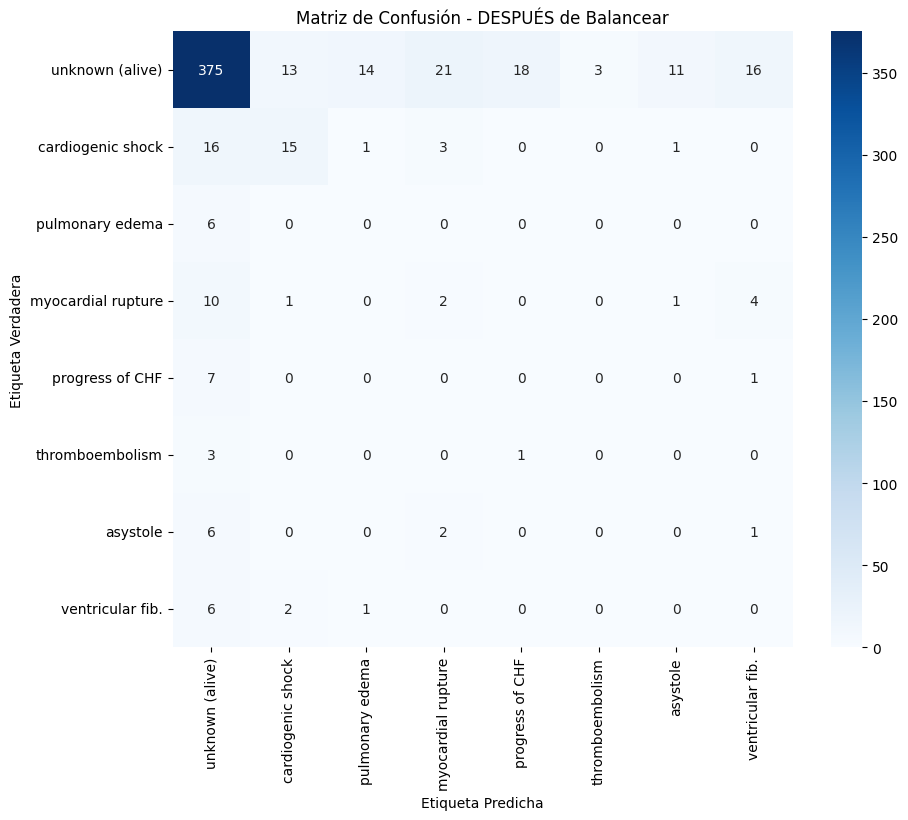

In [ ]:
classifier_balanced = MLPClassifier(solver='adam', random_state=model_seed, activation='relu', alpha=1e-12, tol=1e-12,
                                   hidden_layer_sizes=(10,8), learning_rate='constant',
                                   learning_rate_init=0.01, max_iter=500, momentum=0.9, verbose=False)

classifier_balanced.fit(X_train_balanced, y_train_balanced_encoded)

all_metrics['Con Balanceo'] = evaluate_classifier_and_get_metrics(classifier_balanced, X_test_imp, y_test_imp_encoded, target_names, title_prefix="DESPUÉS de Balancear")

### **D. Prueba 4: Modelo con Balanceo y Normalización**



In [ ]:
# Crear copias para mantener la integridad de los datos
X_train_balanced_norm = X_train_balanced.copy()
X_test_final = X_test_imp.copy() # Usamos una copia del test original

# Crear un nuevo normalizador
scaler_final = MinMaxScaler()

# Ajustar el normalizador solo con los datos numéricos del conjunto de ENTRENAMIENTO BALANCEADO
scaler_final.fit(X_train_balanced[numerical_features])

# Transformar las columnas numéricas tanto en el set de entrenamiento balanceado como en el de prueba original
X_train_balanced_norm[numerical_features] = scaler_final.transform(X_train_balanced[numerical_features])
X_test_final[numerical_features] = scaler_final.transform(X_test_imp[numerical_features])


--- DESPUÉS de Balancear y Normalizar ---
Overall Accuracy: 0.6827

Classification Report:
                    precision    recall  f1-score   support

   unknown (alive)       0.89      0.83      0.86       471
 cardiogenic shock       0.31      0.44      0.37        36
   pulmonary edema       0.06      0.17      0.09         6
myocardial rupture       0.00      0.00      0.00        18
   progress of CHF       0.07      0.12      0.09         8
   thromboembolism       0.00      0.00      0.00         4
          asystole       0.00      0.00      0.00         9
  ventricular fib.       0.07      0.11      0.08         9

         micro avg       0.73      0.73      0.73       561
         macro avg       0.17      0.21      0.19       561
      weighted avg       0.77      0.73      0.75       561
       samples avg       0.71      0.73      0.72       561



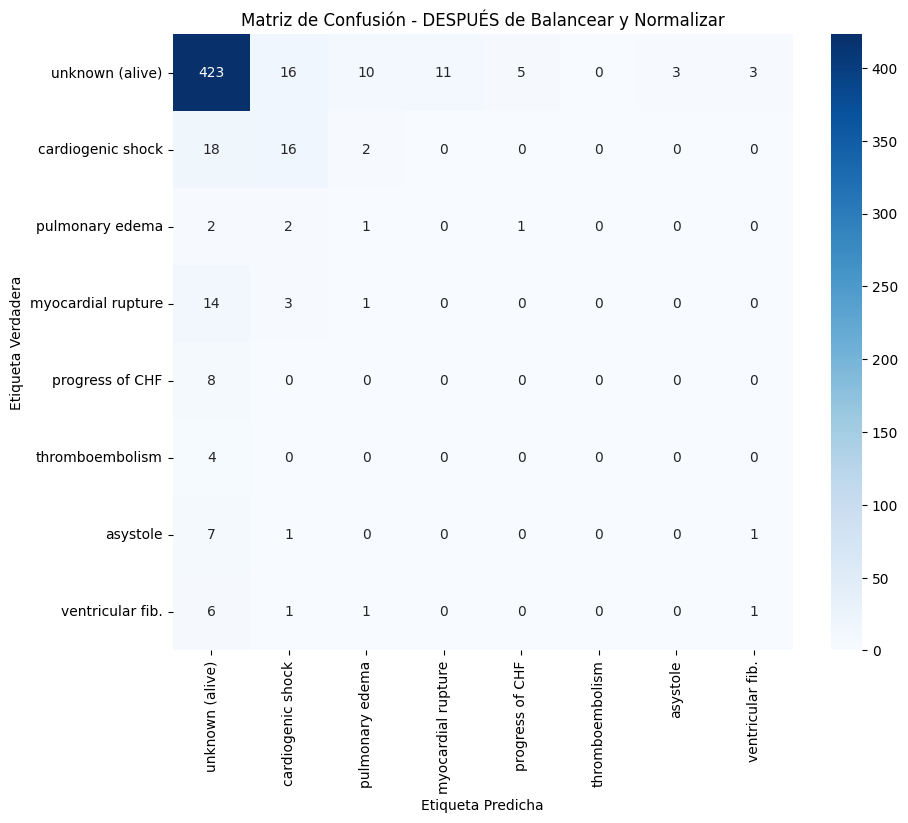

In [ ]:
classifier_balanced_norm = MLPClassifier(solver='adam', random_state=model_seed, activation='relu', alpha=1e-12, tol=1e-12,
                                           hidden_layer_sizes=(10,8), learning_rate='constant',
                                           learning_rate_init=0.01, max_iter=500, momentum=0.9, verbose=False)

classifier_balanced_norm.fit(X_train_balanced_norm, y_train_balanced_encoded)

all_metrics['Con Balanceo y Normalización'] = evaluate_classifier_and_get_metrics(classifier_balanced_norm, X_test_final, y_test_imp_encoded, target_names, title_prefix="DESPUÉS de Balancear y Normalizar")

# **3. Comparación de Resultados**

En este punto, compararemos el rendimiento del Modelo 1 (creado en Laboratorio_No_5_Pt1), que fue entrenado con datos imputados, balanceados con SMOTENC y normalizados, contra el Modelo 2 (creado en Laboratorio_No_5_Pt2), entrenado con el conjunto de datos pre-imputado que fue proporcionado.

## **3.1. Comparacion de resultados unicamente con el conjunto de datos proporcionado**

In [ ]:
# Lista para almacenar los datos procesados para el DataFrame
processed_data = []

# Iterar sobre cada experimento y sus métricas
for model_name, metrics in all_metrics.items():
    # Añadir la fila de Accuracy General
    processed_data.append({
        'Modelo': model_name,
        'Métrica': 'Accuracy',
        'Clase': 'General',
        'Valor': metrics['accuracy']
    })

    # Iterar sobre cada clase en el reporte
    for class_name, class_metrics in metrics.items():
        if isinstance(class_metrics, dict):
            processed_data.append({
                'Modelo': model_name, 'Métrica': 'Precision', 'Clase': class_name, 'Valor': class_metrics['precision']
            })
            processed_data.append({
                'Modelo': model_name, 'Métrica': 'Recall', 'Clase': class_name, 'Valor': class_metrics['recall']
            })
            processed_data.append({
                'Modelo': model_name, 'Métrica': 'F1-score', 'Clase': class_name, 'Valor': class_metrics['f1-score']
            })

# Crear un DataFrame inicial
df_metrics = pd.DataFrame(processed_data)

# Definir el orden deseado para las filas y columnas
model_order = ['Modelo Base', 'Con Normalización', 'Con Balanceo', 'Con Balanceo y Normalización']
metric_order = ['Accuracy', 'Precision', 'Recall', 'F1-score']
class_order = ['General'] + target_names # Pone 'General' primero

# Convertir las columnas a tipo Categórico
df_metrics['Modelo'] = pd.Categorical(df_metrics['Modelo'], categories=model_order, ordered=True)
df_metrics['Métrica'] = pd.Categorical(df_metrics['Métrica'], categories=metric_order, ordered=True)
df_metrics['Clase'] = pd.Categorical(df_metrics['Clase'], categories=class_order, ordered=True)

# 3. Ordenar los datos primero por Clase, luego por Métrica
df_metrics = df_metrics.sort_values(by=['Clase', 'Métrica'])

final_table = df_metrics.pivot_table(
    index=['Clase', 'Métrica'],
    columns='Modelo',
    values='Valor',
    sort=False
)

display(final_table.style.format("{:.3f}").background_gradient(cmap='Greens', axis=1, low=0, high=1))

/tmp/ipython-input-4050183336.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  final_table = df_metrics.pivot_table(


## **3.2. Comparacion de resultados con el conjunto de datos proporcionado y el primer punto desarrollado**

Al comparar los resultados de la red neuronal entrenada con dos enfoques de preprocesamiento distintos. Uno propio (Modelo 1) y otro utilizando los datos proporcionados por el profesor (Modelo 2), se pueden extraer conclusiones importantes sobre el impacto del tratamiento de los datos en la clasificación de complicaciones por infarto de miocardio.

Observaciones Clave:
1. Rendimiento del Modelo Base: Ambos modelos, en su versión base (sin normalización ni balanceo), alcanzaron una alta precisión (Accuracy) general, con 0.837 en el modelo 1 y 0.834 en el modelo 2. Sin embargo, esta métrica es engañosa, ya que está fuertemente influenciada por el rendimiento excepcional en la clase mayoritaria "unknown (alive)". En ambos casos, las métricas de Precisión, Recall y F1-Score para casi todas las clases minoritarias (las complicaciones reales) fueron de cero, lo que indica que el modelo base era incapaz de identificarlas.

2. Impacto del Balanceo y la Normalización: La estrategia más reveladora fue la combinación de Balanceo y Normalización.
  * En el Modelo 1, esta combinación redujo la precisión general a 0.751, pero logró un avance significativo: el modelo fue capaz de obtener un F1-Score superior a cero para la mayoría de las clases minoritarias, incluyendo "edema pulmonar" (0.267), "asistolia" (0.125) y "fibrilación ventricular" (0.211). Esto demuestra que mi preprocesamiento, junto con el balanceo, ayudó al modelo a aprender patrones de clases con muy pocas muestras.
  * En el modelo Modelo 2, la misma estrategia (Balanceo y Normalización) resultó en una precisión general inferior (0.683) y no logró "activar" la predicción para tantas clases. Aunque mejoró la detección de "shock cardiogénico" en algunas variantes, no pudo identificar complicaciones críticas como "ruptura miocárdica" o "tromboembolismo", que mi modelo sí logró capturar, aunque con métricas modestas.

### **3.2.1. Conclusión Final**

El análisis demuestra que el enfoque de preprocesamiento (Modelo 1) fue más efectivo para enfrentar el desafío del desbalance de clases. La combinación de mis técnicas de imputación de datos junto con el balanceo y la normalización, permitió a la red neuronal generalizar mejor y obtener capacidad predictiva sobre un espectro más amplio de complicaciones críticas.
En un problema médico como este, es preferible sacrificar la precisión general para ganar sensibilidad (Recall) en la detección de eventos raros pero potencialmente mortales. Por lo tanto, se concluye que el preprocesamiento utilizado en el punto 1 proporcionó un conjunto de datos más robusto y adecuado a la hora de entrenar el modelo.